In [21]:
import cv2
import numpy as np
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Folders
input_folder = "/content/drive/MyDrive/COLAB/Project/images"
output_folder = "/content/drive/MyDrive/COLAB/Project/masked_images"
output_folder_masks = "/content/drive/MyDrive/COLAB/Project/masked"

# Create output folder & output folder for masks if not exists
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
#jdj
if not os.path.exists(output_folder_masks):
    os.mkdir(output_folder_masks)

In [24]:
# Supported file formats
valid_ext = (".jpg")

In [ ]:
# Loop through all images
for filename in os.listdir(input_folder):
    if filename.lower().endswith(valid_ext):
        print(f"Processing → {filename}")

        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️ Error reading {filename}, skipping...")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # --------- Preprocessing ----------
        img_blur = cv2.GaussianBlur(img, (7, 7), 0)

        # --------- YCrCb Mask -----------
        ycbcr = cv2.cvtColor(img_blur, cv2.COLOR_RGB2YCrCb)
        Y, Cr, Cb = cv2.split(ycbcr)
        mask1 = (Cr >= 135) & (Cr <= 180) & (Cb >= 85) & (Cb <= 135)
        skinmask = mask1.astype(np.uint8)

        # --------- Morphology -----------
        kernel = np.ones((7, 7), np.uint8)
        mask_clean = cv2.morphologyEx(skinmask, cv2.MORPH_OPEN, kernel)
        mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)
        mask_clean = cv2.GaussianBlur(mask_clean, (7,7), 0)

        # --------- Biggest Region Only ------
        num_labels, labels = cv2.connectedComponents(mask_clean)
        if num_labels > 1:
            largest = 1 + np.argmax(np.bincount(labels.ravel())[1:])
            final_mask = (labels == largest).astype(np.uint8) * 255
        else:
            final_mask = mask_clean * 255

        # --------- Apply mask ----------
        skin_only = cv2.bitwise_and(img, img, mask=final_mask)

        # Convert RGB back to BGR for saving
        output_img = cv2.cvtColor(skin_only, cv2.COLOR_RGB2BGR)
        output_mask= cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR)

        # Save result
        output_path = os.path.join(output_folder, "masked_" + filename)
        output_path_mask = os.path.join(output_folder_masks, "mask_" + filename)
        cv2.imwrite(output_path, output_img)
        cv2.imwrite(output_path_mask, output_mask)

        print(f"✅ Saved → {output_path}")

In [30]:

pred_folder = "/content/drive/MyDrive/COLAB/Project/masked"
gt_folder   = "/content/drive/MyDrive/COLAB/Project/ground_truth_masks"
output_csv  = "/content/drive/MyDrive/COLAB/Project/evaluation_results.csv"


# ---- Function: Compare predicted vs ground truth ----
def evaluate(predicted, groundtruth):
    predicted = predicted // 255
    groundtruth = groundtruth // 255

    tp = np.sum((predicted == 1) & (groundtruth == 1))
    tn = np.sum((predicted == 0) & (groundtruth == 0))
    fp = np.sum((predicted == 1) & (groundtruth == 0))
    fn = np.sum((predicted == 0) & (groundtruth == 1))

    accuracy  = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    precision = tp / (tp + fp + 1e-6)
    recall    = tp / (tp + fn + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)
    iou       = tp / (tp + fp + fn + 1e-6)

    return accuracy, precision, recall, f1, iou


# ---- Save results list ----
results = [["Image", "Accuracy", "Precision", "Recall", "F1 Score", "IoU"]]


# ---- Loop through predicted masks ----
for filename in os.listdir(pred_folder):

    if filename.lower().endswith(valid_ext):

        # Convert "mask_img (X).jpg" → "img (X).jpg"
        gt_filename = filename.replace("mask_", "")
        # Now gt_filename = "img (X).jpg"

        pred_path = os.path.join(pred_folder, filename)
        gt_path   = os.path.join(gt_folder, gt_filename)

        # If groundtruth file missing → skip
        if not os.path.exists(gt_path):
            print(f"⚠️ WARNING: No matching GT for {filename} → expected {gt_filename}")
            continue

        # Read images
        predicted = cv2.imread(pred_path, 0)
        ground_truth = cv2.imread(gt_path, 0)

        # Resize if mismatch
        if predicted.shape != ground_truth.shape:
            ground_truth = cv2.resize(ground_truth, (predicted.shape[1], predicted.shape[0]))

        # Evaluate
        accuracy, precision, recall, f1, iou = evaluate(predicted, ground_truth)

        results.append([filename, accuracy, precision, recall, f1, iou])
        print(f"✔ Evaluated {filename}")


# ---- Save CSV ----
with open(output_csv, "w", newline="") as f:
    csv.writer(f).writerows(results)

print("\n🎉 Automated evaluation complete!")
print(f"📄 Results saved in: {output_csv}")


✔ Evaluated mask_img (735).jpg
✔ Evaluated mask_img (447).jpg
✔ Evaluated mask_img (781).jpg
✔ Evaluated mask_img (502).jpg
✔ Evaluated mask_img (294).jpg
✔ Evaluated mask_img (152).jpg
✔ Evaluated mask_img (848).jpg
✔ Evaluated mask_img (389).jpg
✔ Evaluated mask_img (809).jpg
✔ Evaluated mask_img (673).jpg
✔ Evaluated mask_img (1110).jpg
✔ Evaluated mask_img (1055).jpg
✔ Evaluated mask_img (48).jpg
✔ Evaluated mask_img (665).jpg
✔ Evaluated mask_img (1043).jpg
✔ Evaluated mask_img (370).jpg
✔ Evaluated mask_img (720).jpg
✔ Evaluated mask_img (366).jpg
✔ Evaluated mask_img (624).jpg
✔ Evaluated mask_img (1014).jpg
✔ Evaluated mask_img (331).jpg
✔ Evaluated mask_img (761).jpg
✔ Evaluated mask_img (223).jpg
✔ Evaluated mask_img (736).jpg
✔ Evaluated mask_img (448).jpg
✔ Evaluated mask_img (330).jpg
✔ Evaluated mask_img (275).jpg
✔ Evaluated mask_img (274).jpg
✔ Evaluated mask_img (1042).jpg
✔ Evaluated mask_img (1106).jpg
✔ Evaluated mask_img (625).jpg
✔ Evaluated mask_img (1015).jpg
✔ 

In [35]:

# Load CSV
csv_path = "/content/drive/MyDrive/COLAB/Project/evaluation_results.csv"
df = pd.read_csv(csv_path)

# ----------------------------
# 1) Compute Average Metrics
# ----------------------------
avg_metrics = df[["Accuracy", "Precision", "Recall", "F1 Score", "IoU"]].mean()
print("===== AVERAGE METRICS =====")
print(avg_metrics)
print("\n")

# ----------------------------
# 2) Compute Weighted Final Score
# ----------------------------
df["FinalScore"] = (
    df["IoU"] * 0.50 +
    df["F1 Score"] * 0.25 +
    df["Precision"] * 0.15 +
    df["Recall"] * 0.10
)

# ----------------------------
# 3) Assign Status
# ----------------------------
def classify(score):
    if score >= 0.75:
        return "Pass"
    elif score >= 0.50:
        return "Partial"
    else:
        return "Fail"

df["Status"] = df["FinalScore"].apply(classify)

# ----------------------------
# 4) Save Updated CSV
# ----------------------------
output_csv = "/content/drive/MyDrive/COLAB/Project/evaluation_results_with_status.csv"
df.to_csv(output_csv, index=False)
print("✅ Updated CSV saved to:", output_csv)

# ----------------------------
# 5) Display first rows
# ----------------------------
df.head()


===== AVERAGE METRICS =====
Accuracy     0.914872
Precision    0.879075
Recall       0.845825
F1 Score     0.847928
IoU          0.753521
dtype: float64


✅ Updated CSV saved to: /content/drive/MyDrive/COLAB/Project/evaluation_results_with_status.csv


,Image,Accuracy,Precision,Recall,F1 Score,IoU,FinalScore,Status
0,mask_img (735).jpg,0.957263,0.931555,0.899097,0.915038,0.843383,0.880094,Pass
1,mask_img (447).jpg,0.960859,0.906896,0.958408,0.931940,0.872555,0.901138,Pass
2,mask_img (781).jpg,0.924764,0.923733,0.872721,0.897502,0.814063,0.857239,Pass
3,mask_img (502).jpg,0.876872,0.831346,0.784814,0.807409,0.677022,0.743547,Partial
4,mask_img (294).jpg,0.845411,0.631593,0.832128,0.718123,0.560212,0.637589,Partial


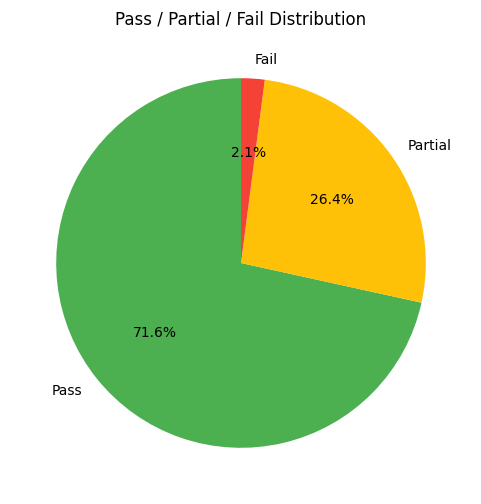

In [34]:


# Load CSV (updated with Status)
csv_path = "/content/drive/MyDrive/COLAB/Project/evaluation_results_with_status.csv"
df = pd.read_csv(csv_path)

# Count number of images in each Status category
status_counts = df["Status"].value_counts()

# Pie Chart
plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=["#4CAF50","#FFC107","#F44336"])
plt.title("Pass / Partial / Fail Distribution")
plt.show()


SyntaxError: invalid character '→' (U+2192) (ipython-input-4191658418.py, line 1)